In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression 
from keras.models import Sequential 
from keras.layers import Dense
from keras.regularizers import l2

Using TensorFlow backend.


In [5]:
# Lectura de datos
from google.colab import files

uploaded = files.upload()
import pandas as pd
import io

data = pd.read_csv(io.StringIO(uploaded['Risk.csv'].decode('utf-8')),sep='\t')

data.head()

Saving Risk.csv to Risk (1).csv


,Edad,Ingresos,Genero,EstadoCivil,NumeroHijos,FormaPagoSalarial,Prestamos,RiesgoDePago,deudas
0,44,59.944,m,married,1.0,monthly,0.0,bueno,5.0
1,35,59.692,m,married,1.0,monthly,0.0,malo,3.0
2,34,59.463,m,married,0.0,monthly,1.0,malo,4.0
3,39,59.393,f,married,0.0,monthly,0.0,bueno,4.0
4,42,59.201,m,married,0.0,monthly,0.0,bueno,4.0


## Exploración de la base

In [6]:
# Verificación de no existencia de datos NA 
data.isnull().sum()

Edad                 0
Ingresos             0
Genero               0
EstadoCivil          0
NumeroHijos          0
FormaPagoSalarial    0
Prestamos            0
RiesgoDePago         0
deudas               0
dtype: int64

## Equilibrar la data

Debido a que la proporcion de las categorias de nuestra target no se encuentra equilibrada.


In [8]:
frecuencia = pd.value_counts(data.RiesgoDePago).to_frame().reset_index()
frecuencia.rename(columns={"index":"RiesgoDePago","RiesgoDePago":"Frecuencia"})

,RiesgoDePago,Frecuencia
0,bueno,3211
1,malo,906


Se procede a sacar una muestra de los buenos pagadores para lograr ese equilibro.

In [9]:
#Separar los buenos de los malos
data_malos = data.loc[data['RiesgoDePago'] == 'malo']
data_buenos = data.loc[data['RiesgoDePago'] == 'bueno']

#Se saca una muestra de aproximadamente el 28% de Riesgo de pago: 'buenos' (porcentaje de malos respecto a los buenos, 
#mediante muestra aleatoria simple)
data_buenos_subset = data_buenos.sample(frac=(906/3211), random_state=1) 

In [10]:
data_buenos_subset.head()

,Edad,Ingresos,Genero,EstadoCivil,NumeroHijos,FormaPagoSalarial,Prestamos,RiesgoDePago,deudas
3917,22,17.193,m,single,1.0,monthly,1.0,bueno,4.0
2537,34,44.617,f,married,1.0,monthly,1.0,bueno,5.0
213,36,42.175,m,married,0.0,monthly,1.0,bueno,3.0
2298,18,16.394,f,married,1.0,monthly,1.0,bueno,5.0
981,20,24.519,m,married,1.0,weekly,1.0,bueno,5.0


In [11]:
#Unir ambos dataset (buenos y malos con 906 observaciones cada uno)
data_equilibrado = pd.concat([data_buenos_subset, data_malos])

# Solo por estrategia procedemos a ordenar las variables en orden genealogico
random_data_equilibrado = data_equilibrado[['Genero', 
                                                   'Edad', 
                                                    'EstadoCivil',    
                                                   'FormaPagoSalarial',
                                                   'Ingresos', 
                                                   'NumeroHijos',
                                                   'Prestamos',
                                                   'RiesgoDePago',
                                                   'deudas']]

In [12]:
#Data equilibrada
frecuencia = pd.value_counts(random_data_equilibrado.RiesgoDePago).to_frame().reset_index()
frecuencia.rename(columns={"index":"RiesgoDePago","RiesgoDePago":"Frecuencia"})

,RiesgoDePago,Frecuencia
0,bueno,906
1,malo,906


# Pruebas estadistícas: Comparación de medias y prueba Ji-cuadrado 

Una vez que se ha equilibrado la base, se procede a analizar que variables depende del Riesgo de pago, para ellos procedemos ha realizar pruebas estadísticas como: Comparación de medias y prueba Chi-cuadrado (dependiendo de la variable a tratar). 

In [ ]:
!pip install researchpy


In [18]:
#Librerias
import scipy.stats as stats
import researchpy as rp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt


In [19]:
# comparacion de medias (Cualitativa-cuantitativa)
#La comparación de medias en un sentido más general, abarca la comparación de los valores de una variable continua
#según los valores de una variable (o factor) que se puede resumir en dos o más categorías y que 
# se engloba dentro de las pruebas para datos independientes

#Hipótesis:
#H0: No hay diferencia entre medias
#H1: La diferencia entre medias existe en alguna parte
#Si el valor p es menor que el nivel de significancia de 0.05, usted puede rechazar la hipótesis nula 
#y concluir que tienen medias diferentes.

    #Edad
stats.f_oneway(random_data_equilibrado['Edad'][random_data_equilibrado['RiesgoDePago'] == 'bueno'], 
             random_data_equilibrado['Edad'][random_data_equilibrado['RiesgoDePago'] == 'malo'])
    # F_onewayResult(statistic=236.798716736885, pvalue=1.7544863401463463e-48)
        
    #Ingresos
stats.f_oneway(random_data_equilibrado['Ingresos'][random_data_equilibrado['RiesgoDePago'] == 'bueno'], 
             random_data_equilibrado['Ingresos'][random_data_equilibrado['RiesgoDePago'] == 'malo'])
#F_onewayResult(statistic=1.2022047854113147, pvalue=0.2731247544439312)

    #NumeroHijos
stats.f_oneway(random_data_equilibrado['NumeroHijos'][random_data_equilibrado['RiesgoDePago'] == 'bueno'], 
             random_data_equilibrado['NumeroHijos'][random_data_equilibrado['RiesgoDePago'] == 'malo'])
#F_onewayResult(statistic=162.73895797621637, pvalue=7.894482576404779e-35)    

    #deudas
stats.f_oneway(random_data_equilibrado['deudas'][random_data_equilibrado['RiesgoDePago'] == 'bueno'], 
             random_data_equilibrado['deudas'][random_data_equilibrado['RiesgoDePago'] == 'malo'])
#F_onewayResult(statistic=466.9803580798752, pvalue=2.5415873552138156e-92)


F_onewayResult(statistic=466.9803580798752, pvalue=2.5415873552138156e-92)

De los resultados obtenidos, se puede observar que la variable ingresos no se deberia considerar en el modelo, pero esto no es posible. Por lo que procedemos a crear una nueva variable que la involucre, esta es ingresos por hijos. Esta variable solamente se crea cuando el numero de hijos es mayor a 0, caso contrario, el valor es 0.

In [20]:
#Ingresos por hijos
random_data_equilibrado['IngresosPorHijos'] = (random_data_equilibrado['Ingresos']/random_data_equilibrado['NumeroHijos'])

#Para remover la palabra inf de la division por cero, usar replace
random_data_equilibrado['IngresosPorHijos'] = random_data_equilibrado['IngresosPorHijos'].replace([np.inf, -np.inf], 0)

#data_new1 = pd.DataFrame()
random_data_equilibrado.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Genero,Edad,EstadoCivil,FormaPagoSalarial,Ingresos,NumeroHijos,Prestamos,RiesgoDePago,deudas,IngresosPorHijos
3917,m,22,single,monthly,17.193,1.0,1.0,bueno,4.0,17.193
2537,f,34,married,monthly,44.617,1.0,1.0,bueno,5.0,44.617
213,m,36,married,monthly,42.175,0.0,1.0,bueno,3.0,0.000
2298,f,18,married,monthly,16.394,1.0,1.0,bueno,5.0,16.394
981,m,20,married,weekly,24.519,1.0,1.0,bueno,5.0,24.519


In [21]:
    #'IngresosPorHijos'
stats.f_oneway(random_data_equilibrado['IngresosPorHijos'][random_data_equilibrado['RiesgoDePago'] == 'bueno'], 
             random_data_equilibrado['IngresosPorHijos'][random_data_equilibrado['RiesgoDePago'] == 'malo'])
#F_onewayResult(statistic=23.51792050343914, pvalue=1.3434353360311621e-06)

F_onewayResult(statistic=23.51792050343914, pvalue=1.3434353360311621e-06)

Como se observó anteriormente, la variable Ingresos no debe ser tomada encuenta, por lo que se procede a eliminarla

In [22]:
del random_data_equilibrado['Ingresos']
del random_data_equilibrado['NumeroHijos']

In [23]:
#Prueba Chi cuadrado
#se utiliza cuando se tiene una muestra de n individuos que se clasifican respecto a dos variables, preferentemente 
#cualitativas (nominales dicotómicas o politómicas) y se desea conocer a partir de datos muestrales, si existe 
#asociación de estas a nivel poblacional.

#Hipótesis:
#H0: Existe poblacionalmente independencia entre las variables estudiadas 
#H1: No existe poblacionalmente independencia 

from scipy.stats import chisquare

In [27]:
    #Genero    
        #Datos observados 
        #Tabla de contingencia RiesgodePago/ Genero
obs_genero=pd.crosstab(index=random_data_equilibrado['Genero'],
            columns=random_data_equilibrado['RiesgoDePago'], margins=True)

        #Datos esperados
esper_genero=obs_genero
esper_genero['bueno'][0]=(obs_genero['bueno']['All']*obs_genero['All'][0])/obs_genero['All']['All']
esper_genero['bueno'][1]=(obs_genero['bueno']['All']*obs_genero['All'][1])/obs_genero['All']['All']
esper_genero['malo'][0]=(obs_genero['malo']['All']*obs_genero['All'][0])/obs_genero['All']['All']
esper_genero['malo'][1]=(obs_genero['malo']['All']*obs_genero['All'][1])/obs_genero['All']['All']

        #Prueba chi-cuadrado
observed = np.array([459,457,447,449])
expected = np.array([458,458,448,448]) 
chisquare(observed, expected)

#Power_divergenceResult(statistic=0.00883109794135995, pvalue=0.999779864258932)  

    #EstadoCivil
        #Datos observados
        #Tabla de contingencia RiesgodePago/ EstadoCivil
obs_EstadoCivil=pd.crosstab(index=random_data_equilibrado['EstadoCivil'],
            columns=random_data_equilibrado['RiesgoDePago'], margins=True)

         #Datos esperados
esper_EstadoCivil=obs_EstadoCivil
esper_EstadoCivil['bueno']['divsepwid']=(obs_EstadoCivil['bueno']['All']*obs_EstadoCivil['All']['divsepwid'])/obs_EstadoCivil['All']['All']
esper_EstadoCivil['malo']['divsepwid']=(obs_EstadoCivil['bueno']['All']*obs_EstadoCivil['All']['divsepwid'])/obs_EstadoCivil['All']['All']

esper_EstadoCivil['bueno']['married']=(obs_EstadoCivil['bueno']['All']*obs_EstadoCivil['All']['married'])/obs_EstadoCivil['All']['All']
esper_EstadoCivil['malo']['married']=(obs_EstadoCivil['bueno']['All']*obs_EstadoCivil['All']['married'])/obs_EstadoCivil['All']['All']

esper_EstadoCivil['bueno']['single']=(obs_EstadoCivil['bueno']['All']*obs_EstadoCivil['All']['single'])/obs_EstadoCivil['All']['All']
esper_EstadoCivil['malo']['single']=(obs_EstadoCivil['bueno']['All']*obs_EstadoCivil['All']['single'])/obs_EstadoCivil['All']['All']


        #Prueba chi-cuadrado
observed = np.array([153,297,461,507,292,102])
expected = np.array([225,225,484,484,197,197]) 
chisquare(observed, expected)
#Power_divergenceResult(statistic=139.89031589545664, pvalue=1.88792185947729e-28)
    
    #FormaPagoSalarial
        #Datos observados
        #Tabla de contingencia RiesgodePago/ FormaPagoSalarial
obs_FormaPagoSalarial=pd.crosstab(index=random_data_equilibrado['FormaPagoSalarial'],
            columns=random_data_equilibrado['RiesgoDePago'], margins=True)

         #Datos esperados
esper_FormaPagoSalarial=obs_FormaPagoSalarial
esper_FormaPagoSalarial['bueno']['monthly']=(obs_FormaPagoSalarial['bueno']['All']*obs_FormaPagoSalarial['All']['monthly'])/obs_FormaPagoSalarial['All']['All']
esper_FormaPagoSalarial['malo']['monthly']=(obs_FormaPagoSalarial['bueno']['All']*obs_FormaPagoSalarial['All']['monthly'])/obs_FormaPagoSalarial['All']['All']

esper_FormaPagoSalarial['bueno']['weekly']=(obs_FormaPagoSalarial['bueno']['All']*obs_FormaPagoSalarial['All']['weekly'])/obs_FormaPagoSalarial['All']['All']
esper_FormaPagoSalarial['malo']['weekly']=(obs_FormaPagoSalarial['bueno']['All']*obs_FormaPagoSalarial['All']['weekly'])/obs_FormaPagoSalarial['All']['All']

        #Prueba chi-cuadrado
observed = np.array([483,359,423,547])
expected = np.array([421,421,485,485]) 
chisquare(observed, expected)
#Power_divergenceResult(statistic=34.11282905208512, pvalue=1.8754503745781636e-07) 

Power_divergenceResult(statistic=34.11282905208512, pvalue=1.8754503745781636e-07)

De la prueba chi cuadrado se observa que la variable genero no debe incluirse en el modelo, por lo que se procede a eliminarla

In [28]:
del random_data_equilibrado['Genero']
random_data_equilibrado.head()

,Edad,EstadoCivil,FormaPagoSalarial,Prestamos,RiesgoDePago,deudas,IngresosPorHijos
3917,22,single,monthly,1.0,bueno,4.0,17.193
2537,34,married,monthly,1.0,bueno,5.0,44.617
213,36,married,monthly,1.0,bueno,3.0,0.000
2298,18,married,monthly,1.0,bueno,5.0,16.394
981,20,married,weekly,1.0,bueno,5.0,24.519


# Transformacion de variables categóricas a numéricas

Por otro lado, debido a que para trabajar con python es necesario trabajar con variables de tipo numérica, se procede a cambiar el tipo de variable

In [ ]:
#Cambio de variables de categoricas a numericas

#Variable 'EstadoCivil'
data_new = pd.get_dummies(random_data_equilibrado,columns=["EstadoCivil"])

In [ ]:
#Variable 'FormaPagoSalarial'
#FormaPagoSalarial: 1 weekly; 0 monthly 
data_new1 = pd.get_dummies(data_new,columns=["FormaPagoSalarial"],drop_first=True)

In [ ]:
#Variable 'RiesgoDePago'
#Riesgo de pago: 1 (Si): Si es riesgoso(Mal pagador); 0 (No): No es riesgoso(Buen pagador) 
data_1 = pd.get_dummies(data_new1,columns=["RiesgoDePago"],drop_first=True)

In [ ]:
data_1.head()

,Edad,Prestamos,deudas,IngresosPorHijos,EstadoCivil_divsepwid,EstadoCivil_married,EstadoCivil_single,FormaPagoSalarial_weekly,RiesgoDePago_malo
3917,22,1.0,4.0,17.193,0,0,1,0,0
2537,34,1.0,5.0,44.617,0,1,0,0,0
213,36,1.0,3.0,0.000,0,1,0,0,0
2298,18,1.0,5.0,16.394,0,1,0,0,0
981,20,1.0,5.0,24.519,0,1,0,1,0


# Particionamiento: split

Previo al analisis de los modelos, se procede a particionar la base en entrenamiento (60%), validacion (20%) y prueba (20%).

In [29]:
from sklearn.model_selection import train_test_split

In [31]:
train,validate1=train_test_split(data_1,train_size=0.6, random_state = 1)

In [32]:
validate,test=train_test_split(validate1,train_size=0.5, random_state = 1)

In [33]:
#Data equilibrada
frecuencia = pd.value_counts(train.RiesgoDePago_malo).to_frame().reset_index()
frecuencia.rename(columns={"index":"RiesgoDePago","RiesgoDePago_malo":"Frecuencia"})

AttributeError: ignored

In [ ]:
#Data equilibrada
frecuencia = pd.value_counts(validate.RiesgoDePago_malo).to_frame().reset_index()
frecuencia.rename(columns={"index":"RiesgoDePago","RiesgoDePago_malo":"Frecuencia"})

,RiesgoDePago,Frecuencia
0,1,183
1,0,179


In [ ]:
#Data equilibrada
frecuencia = pd.value_counts(test.RiesgoDePago_malo).to_frame().reset_index()
frecuencia.rename(columns={"index":"RiesgoDePago","RiesgoDePago_malo":"Frecuencia"})

,RiesgoDePago,Frecuencia
0,0,187
1,1,176


# Entrada y salida q ingresarán a los modelos

In [ ]:
#x entrada
x_train = train.values[:,0:8]
x_validate = validate.values[:,0:8]
x_test = test.values[:,0:8]
#y targets
y_train = train.values[:,8] #para cada fila, va a tener un valor 
y_validate = validate.values[:,8]
y_test = test.values[:,8]

## Escalar Variables

Si observamos los datos detenidamente podemos apreciar que hay variables que contienen valores muy altos y otras que sólo toman valores 1 o 0. No queremos que ninguna variable domine a las demás por lo que escalaremos los datos.

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_validate = sc.fit_transform(x_validate)
x_test = sc.fit_transform(x_test)

# Modelo:  Regresión logística

Debido a que nuestro objetivo es clasificar a una persona en buen o mal pagador (Riesgo de Pago) de acuerdo a ciertas características (edad, ingresos por hijos, deudas, etc) una opción es utilizar un modelo de regresión logística.

In [ ]:
#Regresion Logistica

rl = LogisticRegression(penalty='l2',solver='sag',max_iter=50,random_state=1)#si esq es una regresion tendría que cambiar los parámetros

#ajustar los datos
rl.fit(x_train,y_train)
score_rl = rl.score(x_train, y_train)
#valor del score 
print('Precisión: {:.2f}'.format(score_rl))


Precisión: 0.74


In [ ]:
#Matriz de confusion
from sklearn.metrics import confusion_matrix
y_pred = rl.predict(x_train)
regresion_logistica_confusion_matrix_train = confusion_matrix(y_train, y_pred)
print('Regresion Logistica: Matriz de confusion (Train)')
print(regresion_logistica_confusion_matrix_train)

Regresion Logistica: Matriz de confusion (Train)
[[420 120]
 [165 382]]


In [ ]:
# Reporte de clasificación.
from sklearn.metrics import classification_report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

         0.0       0.72      0.78      0.75       540
         1.0       0.76      0.70      0.73       547

    accuracy                           0.74      1087
   macro avg       0.74      0.74      0.74      1087
weighted avg       0.74      0.74      0.74      1087



In [ ]:
#Validacion
#valor del score 
print('Precisión: {:.2f}'.format(rl.score(x_validate, y_validate)))

Precisión: 0.74


In [ ]:
#Matriz de confusion
from sklearn.metrics import confusion_matrix
y_pred = rl.predict(x_validate)
regresion_logistica_confusion_matrix_validate = confusion_matrix(y_validate, y_pred)
print('Regresion Logistica: Matriz de confusion (Validate)')
print(regresion_logistica_confusion_matrix_validate)

Regresion Logistica: Matriz de confusion (Validate)
[[137  42]
 [ 51 132]]


In [ ]:
# Reporte de clasificación.
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

         0.0       0.73      0.77      0.75       179
         1.0       0.76      0.72      0.74       183

    accuracy                           0.74       362
   macro avg       0.74      0.74      0.74       362
weighted avg       0.74      0.74      0.74       362



In [ ]:
#Prueba
#valor del score 
print('Precisión: {:.2f}'.format(rl.score(x_test, y_test)))

Precisión: 0.74


In [ ]:
#Matriz de confusion
from sklearn.metrics import confusion_matrix
y_pred = rl.predict(x_test)
regresion_logistica_confusion_matrix_test = confusion_matrix(y_test, y_pred)
print('Regresion Logistica: Matriz de confusion (Test)')
print(regresion_logistica_confusion_matrix_test)

Regresion Logistica: Matriz de confusion (Test)
[[144  43]
 [ 51 125]]


In [ ]:
# Reporte de clasificación.
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.74      0.77      0.75       187
         1.0       0.74      0.71      0.73       176

    accuracy                           0.74       363
   macro avg       0.74      0.74      0.74       363
weighted avg       0.74      0.74      0.74       363



# GRÁFICOS DE DISTRIBUCIÓN
Previo a la construcción del modelo, se procede a observar los siguiente gráficos.

In [ ]:
import plotnine as p9

Edad- IngresosPor Hijos (RiesgodePago)

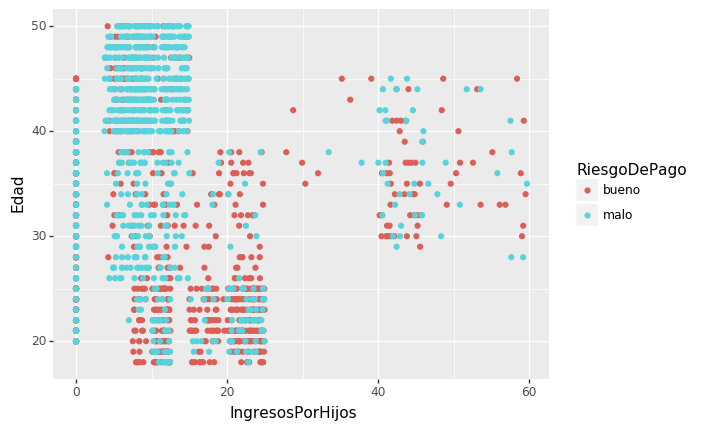

<ggplot: (-9223371937508987656)>

In [ ]:
# Crea un marco para el gráfico definiendo las variables
surveys_plot = p9.ggplot(data=random_data_equilibrado,
                         mapping=p9.aes(x='IngresosPorHijos', y='Edad',
                          color='RiesgoDePago'))

# Dibuja los puntos en el marco
surveys_plot + p9.geom_point()

Edad-deudas (RiesgodePago)

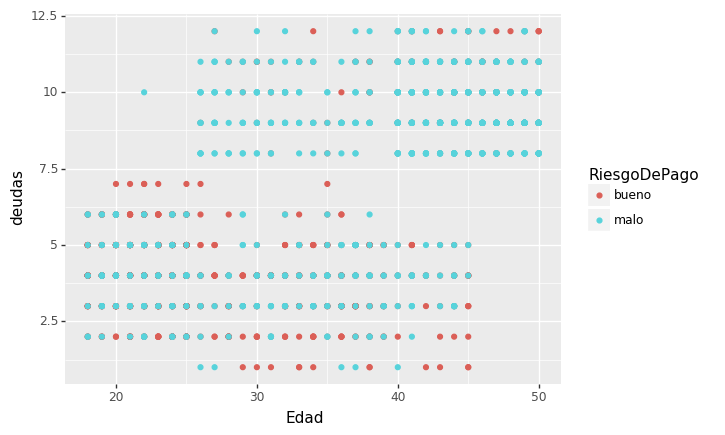

<ggplot: (-9223371937508957636)>

In [ ]:
# Crea un marco para el gráfico definiendo las variables
surveys_plot = p9.ggplot(data=random_data_equilibrado,
                         mapping=p9.aes(x='Edad', y='deudas',
                          color='RiesgoDePago'))

# Dibuja los puntos en el marco
surveys_plot + p9.geom_point()

Prestamos-IngresosPorHijos(RiesgoDePago)

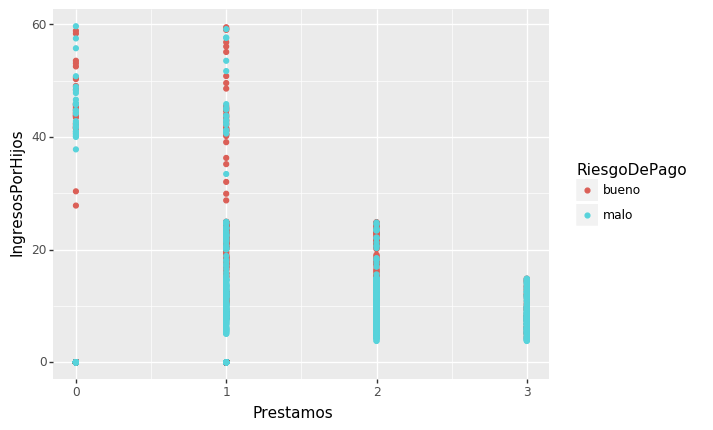

<ggplot: (-9223371937508809980)>

In [ ]:
# Crea un marco para el gráfico definiendo las variables
surveys_plot = p9.ggplot(data=random_data_equilibrado,
                         mapping=p9.aes(x='Prestamos', y='IngresosPorHijos',
                          color='RiesgoDePago'))

# Dibuja los puntos en el marco
surveys_plot + p9.geom_point()

# Modelo: Red Neuronal

In [ ]:
from sklearn.model_selection import KFold 
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import cross_val_score 

Como se observan en las gráficas antes presentadas, no se debe trabajar con una función de activación lineal, por lo que, se trabaja con sigmoidal, tangencial o hasta una softmax

Capa de salida : Tangencias

Capa oculta: Sigmoides

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


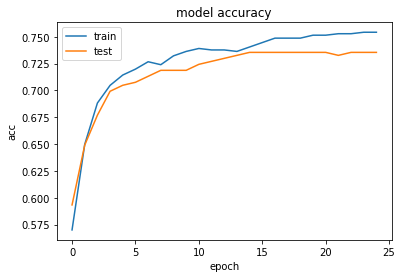

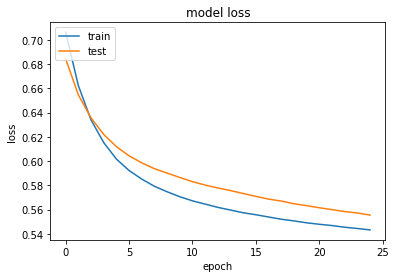

******Entrenamiento*******
1087/1087 [==============================] - 0s 19us/step
Red Neuronal - Precision: 
acc: 74.89%
Red Neuronal - Perdida: 
loss: 54.65%
Red Neuronal: Matriz de confusion (Train)
[[409 131]
 [142 405]]
*******Validate*******
362/362 [==============================] - 0s 22us/step
Red Neuronal - Precision: 
acc: 72.38%
Red Neuronal - Perdida: 
loss: 56.59%
Red Neuronal: Matriz de confusion (Validate)
[[128  51]
 [ 49 134]]
*******Test*******
363/363 [==============================] - 0s 19us/step
Red Neuronal - Precision: 
acc: 73.28%
Red Neuronal - Perdida: 
loss: 57.37%
Red Neuronal: Matriz de confusion (Test)
[[137  50]
 [ 47 129]]


In [ ]:
#Red neuronal.

#Utilizando Redes neuronales, puedo meter muchas capas y puedo manipular
modelo = Sequential()
modelo.add(Dense(3,input_dim=8,kernel_regularizer=l2(0.),activation='tanh'))#Capa de salida
modelo.add(Dense(1,kernel_regularizer=l2(0.),activation='sigmoid'))#Capa oculta 
modelo.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
#modelo.fit(x_train,y_train,validation_split=0.33,epochs=25,batch_size=10,verbose=0)
history =modelo.fit(x_train,y_train,validation_split=0.33,epochs=25,batch_size=10,verbose=0)
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


print( "******Entrenamiento*******")
#Evaluacion del modelo
scores = modelo.evaluate(x_train,y_train)
print("Red Neuronal - Precision: \n%s: %.2f%%" % (modelo.metrics_names[1], scores[1]*100))#Accuracy (exactitud)
print("Red Neuronal - Perdida: \n%s: %.2f%%" % (modelo.metrics_names[0], scores[0]*100))#Perdida



#Matriz de confusion
#Entrenamiento
from sklearn.metrics import confusion_matrix
y_pred_train = modelo.predict(x_train)
# redondeamos las predicciones
rounded_y_pred_train = [round(x[0]) for x in y_pred_train]
red_neuronal_confusion_matrix_train = confusion_matrix(y_train, rounded_y_pred_train)
print('Red Neuronal: Matriz de confusion (Train)')
print(red_neuronal_confusion_matrix_train)

#Validacion
print( "*******Validate*******")

y_pred_validate = modelo.predict(x_validate)
# redondeamos las predicciones
rounded_y_pred_validate = [round(x[0]) for x in y_pred_validate]
scores_validate = modelo.evaluate(x_validate,y_validate)
print("Red Neuronal - Precision: \n%s: %.2f%%" % (modelo.metrics_names[1], scores_validate[1]*100))#Accuracy (exactitud)
print("Red Neuronal - Perdida: \n%s: %.2f%%" % (modelo.metrics_names[0], scores_validate[0]*100))#Perdida


#matriz de confusion
red_neuronal_confusion_matrix_validate = confusion_matrix(y_validate, rounded_y_pred_validate)
print('Red Neuronal: Matriz de confusion (Validate)')
print(red_neuronal_confusion_matrix_validate)


print( "*******Test*******")

#Prueba
y_pred_test = modelo.predict(x_test)
# redondeamos las predicciones
rounded_y_pred_test = [round(x[0]) for x in y_pred_test]

scores_test = modelo.evaluate(x_test,y_test)
print("Red Neuronal - Precision: \n%s: %.2f%%" % (modelo.metrics_names[1], scores_test[1]*100))#Accuracy (exactitud)
print("Red Neuronal - Perdida: \n%s: %.2f%%" % (modelo.metrics_names[0], scores_test[0]*100))#Perdida


red_neuronal_confusion_matrix_test = confusion_matrix(y_test, rounded_y_pred_test)
print('Red Neuronal: Matriz de confusion (Test)')
print(red_neuronal_confusion_matrix_test)
   


# SVM

In [ ]:
from sklearn.svm import SVC
from sklearn import svm, datasets

In [ ]:
svclassifier = SVC(kernel = 'rbf', gamma = 'auto')  
svclassifier.fit(x_train, y_train)

rounded_y_pred_test = svclassifier.predict(x_test)


from sklearn.metrics import confusion_matrix
# redondeamos las predicciones
rounded_y_pred_test = svclassifier.predict(x_test)
SVM_confusion_matrix_test = confusion_matrix(y_test,rounded_y_pred_test)

print('SVM: Matriz de confusion')
print(SVM_confusion_matrix_test)

print('****Reporte Clasificacion***')
print(classification_report(y_test,rounded_y_pred_test))

SVM: Matriz de confusion
[[153  34]
 [ 55 121]]
****Reporte Clasificacion***
              precision    recall  f1-score   support

         0.0       0.74      0.82      0.77       187
         1.0       0.78      0.69      0.73       176

    accuracy                           0.75       363
   macro avg       0.76      0.75      0.75       363
weighted avg       0.76      0.75      0.75       363



In [ ]:
# redondeamos las predicciones
rounded_y_pred_validate = svclassifier.predict(x_validate)
SVM_confusion_matrix_validate = confusion_matrix(y_validate,rounded_y_pred_validate)
print('SVM: Matriz de confusion')
print(SVM_confusion_matrix_validate)

print('****Reporte Clasificacion***')
print(classification_report(y_validate,rounded_y_pred_validate))

SVM: Matriz de confusion
[[143  36]
 [ 51 132]]
****Reporte Clasificacion***
              precision    recall  f1-score   support

         0.0       0.74      0.80      0.77       179
         1.0       0.79      0.72      0.75       183

    accuracy                           0.76       362
   macro avg       0.76      0.76      0.76       362
weighted avg       0.76      0.76      0.76       362



# MODELO: KNN

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
#escalar
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [ ]:
#modelo knn
n_k = 13
knn = KNeighborsClassifier(n_k)

knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                     weights='uniform')

In [ ]:
KNN_score = knn.score(x_train, y_train)
print("KNN - Precision (Train): ", KNN_score)

KNN - Precision (Train):  0.764489420423183


In [ ]:
KNN_scoreTest = knn.score(x_test, y_test)
print("KNN - Precision (Test): ", KNN_scoreTest)

KNN - Precision (Test):  0.7410468319559229


In [ ]:
KNN_predict = knn.predict(x_test)
KNN_confusion_matrix_test = confusion_matrix(y_test, KNN_predict)
print('KNN: Matriz de confusion (Test)')
print(KNN_confusion_matrix_test)

KNN: Matriz de confusion (Test)
[[149  38]
 [ 56 120]]


In [ ]:
print(classification_report(y_test, KNN_predict))

              precision    recall  f1-score   support

         0.0       0.73      0.80      0.76       187
         1.0       0.76      0.68      0.72       176

    accuracy                           0.74       363
   macro avg       0.74      0.74      0.74       363
weighted avg       0.74      0.74      0.74       363



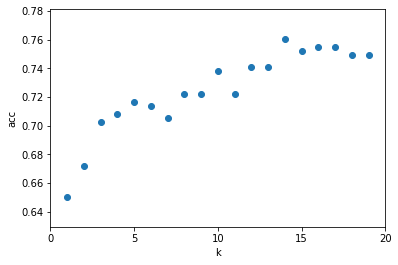

In [ ]:
#¿cuantos k necesito para hacer el modelo knn? con el error me marca 4 pero con la precision de 15

k_range = range(1,20)
scores = []    #creo una lista para ir haciendo un append
for k in k_range:
    
    knn=knn=KNeighborsClassifier(n_neighbors =k)
    knn.fit(x_train,y_train)
    scores.append(knn.score(x_test, y_test)) # saco el accuracy directo o podría sacar el error medio cuadrático
    
plt.figure()
plt.xlabel('k')
plt.ylabel('acc')

plt.scatter(k_range,scores)

plt.xticks([0,5,10,15,20])

plt.show()

In [ ]:
from IPython.display import Image

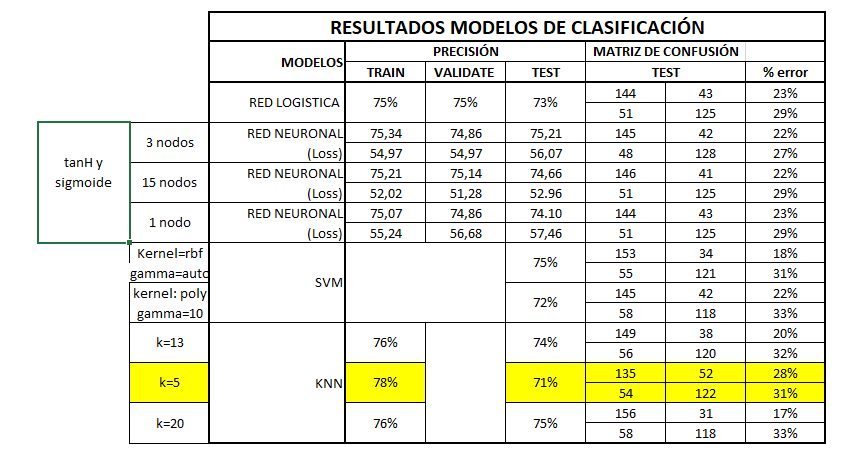

In [ ]:
Image("ModelosCuadro.png")